# Hypothesis 1: Computing Effciency Across Coding Agents

## 1. Load Data



In [3]:
import pandas as pd

from huggingface_hub import login
login("token")


all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")


# AIDev-pop (repositories that have more than 100 stars)
# Basic
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/user.parquet")

# Comments and reviews
pr_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")
pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet")

# Commits
pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
pr_commit_details_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")

# Related issues
related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

# Events
pr_timeline_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_timeline.parquet")

# Task type
pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")

# Human-PR
human_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pull_request.parquet")
human_pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/human_pr_task_type.parquet")

## 2. Preprocess data: Calculating the Average time it takes for a pull request to closed based on the different coding agents

In [6]:
closed_prs = pr_df.loc[pr_df['state'] == 'closed', ['id',"created_at","closed_at","agent"]]
closed_prs['created_at'] = pd.to_datetime(closed_prs['created_at'])
closed_prs['closed_at'] = pd.to_datetime(closed_prs['closed_at'])
closed_prs['time_to_close'] = closed_prs['closed_at'] - closed_prs['created_at']


avg_times = closed_prs.groupby("agent")["time_to_close"].mean()
avg_hours = avg_times.dt.total_seconds() / 3600   # convert to hours
print(avg_hours)

agent
Claude_Code      62.804515
Copilot         101.409403
Cursor           35.177061
Devin            83.757593
OpenAI_Codex     19.415475
Name: time_to_close, dtype: float64


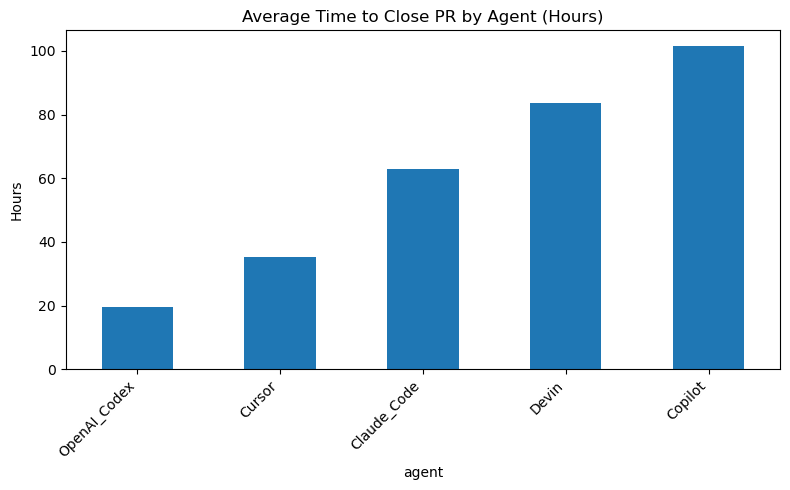

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
avg_hours.sort_values().plot(kind='bar')

plt.title("Average Time to Close PR by Agent (Hours)")
plt.ylabel("Hours")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Preprocess data: Calculate the number of iterations its take for a pull request to close

In [9]:
pr_timeline_filtered_closed = pr_timeline_df[pr_timeline_df['pr_id'].isin(closed_prs['id'])]

In [10]:
merged_timeline_agent = pr_timeline_filtered_closed.merge(
    closed_prs, 
    left_on="pr_id", 
    right_on="id", 
    how="left"
)

In [12]:
counts = merged_timeline_agent[['pr_id', 'agent']].value_counts().reset_index(name='iterations')

counts

,pr_id,agent,iterations
0,3225725945,Claude_Code,60
1,2756921963,Devin,30
2,3226175596,Copilot,30
3,3226500911,Claude_Code,30
4,3023613188,Devin,30
...,...,...,...
31279,3275983098,Cursor,2
31280,3214900515,OpenAI_Codex,2
31281,3222447409,Cursor,2
31282,3222463688,Cursor,2


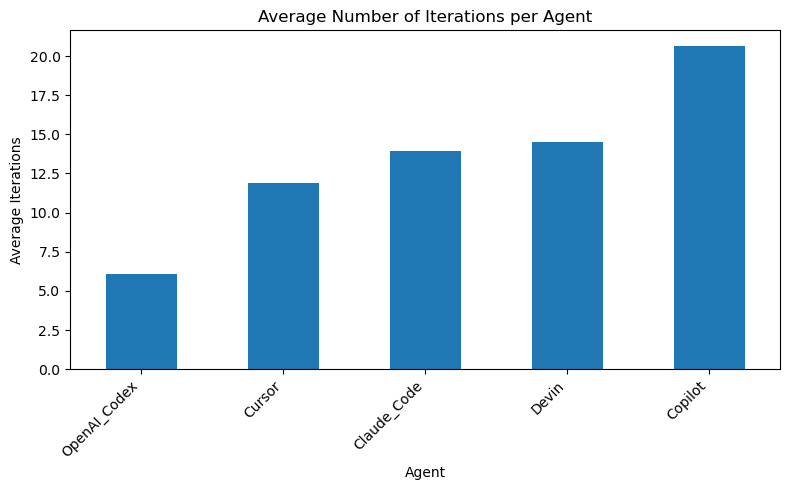

In [13]:
avg_iterations = counts.groupby('agent')['iterations'].mean().sort_values()
plt.figure(figsize=(8,5))
avg_iterations.plot(kind='bar')

plt.title("Average Number of Iterations per Agent")
plt.ylabel("Average Iterations")
plt.xlabel("Agent")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



## 3. Create a dataframe with the nessesary columns

In [36]:
counts_renamed = counts.rename(columns={"pr_id": "id"})

final_df = closed_prs.merge(counts_renamed,on=["id", "agent"],how="left")
final_df["time_to_close_hours"] = final_df["time_to_close"].dt.total_seconds() / 3600



final_df


,id,created_at,closed_at,agent,time_to_close,iterations,time_to_close_hours
0,3264933329,2025-07-26 02:59:01+00:00,2025-07-29 07:01:20+00:00,Claude_Code,3 days 04:02:19,10,76.038611
1,3265118634,2025-07-26 04:56:55+00:00,2025-07-26 22:12:24+00:00,Claude_Code,0 days 17:15:29,5,17.258056
2,3265640341,2025-07-26 13:31:19+00:00,2025-07-26 13:37:22+00:00,Claude_Code,0 days 00:06:03,12,0.100833
3,3265709660,2025-07-26 14:07:22+00:00,2025-07-26 14:45:30+00:00,Claude_Code,0 days 00:38:08,11,0.635556
4,3234102722,2025-07-16 01:00:34+00:00,2025-07-17 12:49:29+00:00,Claude_Code,1 days 11:48:55,9,35.815278
...,...,...,...,...,...,...,...
31279,2857942945,2025-02-17 13:57:22+00:00,2025-02-17 14:40:12+00:00,Devin,0 days 00:42:50,9,0.713889
31280,2857959763,2025-02-17 14:04:15+00:00,2025-02-25 16:39:21+00:00,Devin,8 days 02:35:06,8,194.585000
31281,2858280902,2025-02-17 16:15:35+00:00,2025-02-17 16:23:53+00:00,Devin,0 days 00:08:18,6,0.138333
31282,2858429985,2025-02-17 17:19:32+00:00,2025-02-18 08:32:15+00:00,Devin,0 days 15:12:43,18,15.211944


## Analysis of findings

In [40]:
def five_number_summary(x):
    return pd.Series({
        'Min': x.min(),
        'Q1': x.quantile(0.25),
        'Median': x.median(),
        'Q3': x.quantile(0.75),
        'Max': x.max()
    })

summary = final_df.groupby("agent")["time_to_close_hours"].apply(five_number_summary).unstack().reset_index()  
print(summary)

          agent       Min        Q1     Median          Q3          Max
0   Claude_Code  0.001667  0.250694   1.953194   26.246250  1797.698611
1       Copilot  0.000278  1.113472  13.010000   89.571250  1682.583333
2        Cursor  0.000833  0.087222   0.895556   17.788472   834.492500
3         Devin  0.002222  0.610278   8.911389  123.580000  3549.193333
4  OpenAI_Codex  0.000833  0.004444   0.021667    0.250000  1776.576944


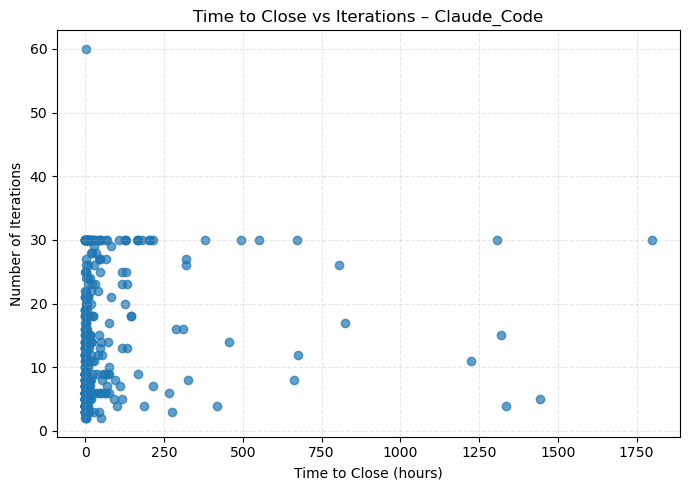

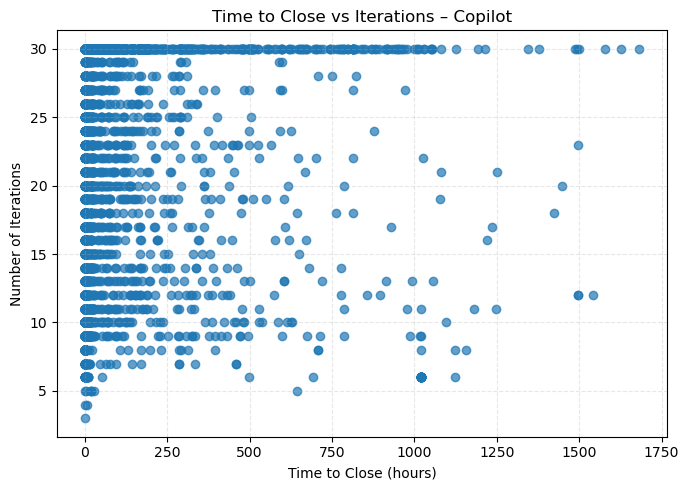

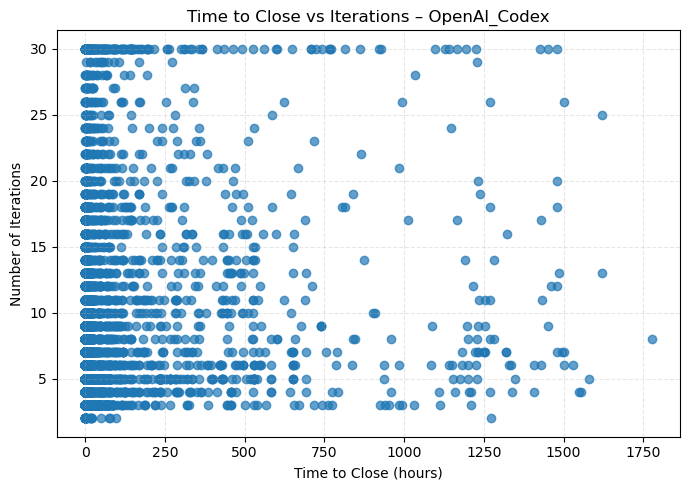

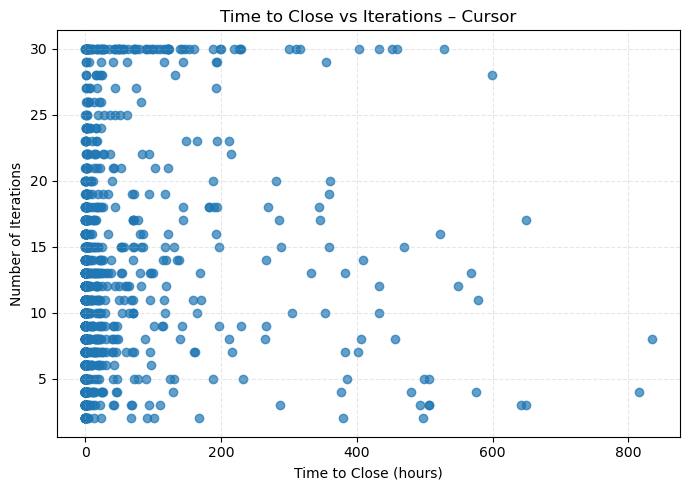

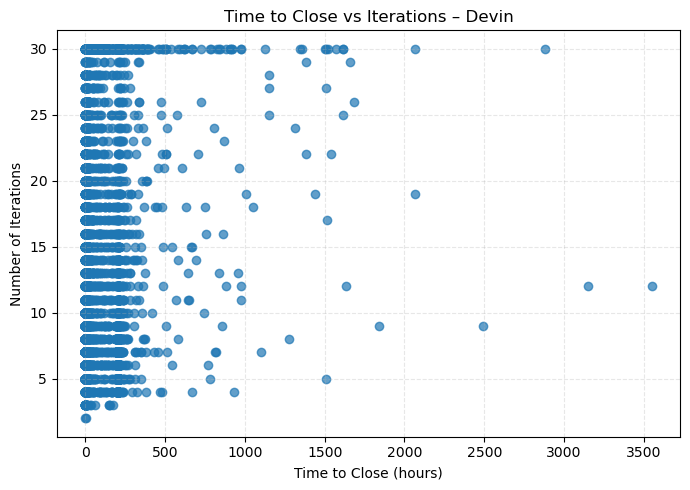

In [39]:

agents = final_df["agent"].unique()

for agent in agents:
    sub = final_df[final_df["agent"] == agent]

    plt.figure(figsize=(7, 5))
    plt.scatter(sub["time_to_close_hours"], sub["iterations"], alpha=0.7)

    plt.title(f"Time to Close vs Iterations – {agent}")
    plt.xlabel("Time to Close (hours)")
    plt.ylabel("Number of Iterations")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()